In [114]:
import time
import copy
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from finetune.cifar10_models import resnet18

# Pre-trained models for dissimilar data

Previously, we have seen the power of pre-trained models in classification of images. In this problem, we show the utility of pre-trained models when performing tasks that are dissimilar to the one they were trained for.

Run the code below to download and visualize the data. It may take a couple minutes to download the data.

In [115]:
class_label_to_name = {0: "T-shirt/top",
                        1: "Trouser",
                        2: "Pullover",
                        3: "Dress",
                        4: "Coat",
                        5: "Sandal",
                        6: "Shirt",
                        7: "Sneaker",
                        8: "Bag",
                        9: "Ankle boot"}

# transforms to match mean and std of original dataset
trfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.4914], [0.2470])])

# download the data
dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, download=True)
val_dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, train=False, download=True)

cifar10 = torchvision.datasets.CIFAR10('data', download=True)

Files already downloaded and verified


## Part a

For this question, we will be working with ResNet-18 pre-trained on ImageNet. Our task will be to classify types of clothing from a dataset called Fashion-MNIST.

First, let's visualize the data from both datasets. Run the following cells and then answer the questions below.

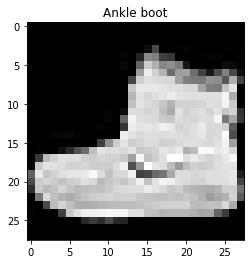

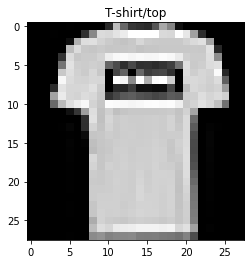

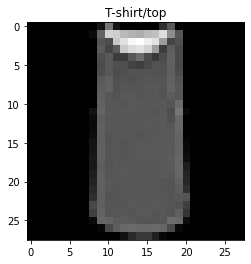

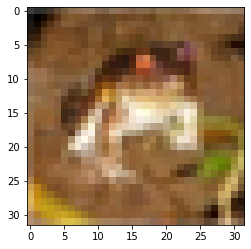

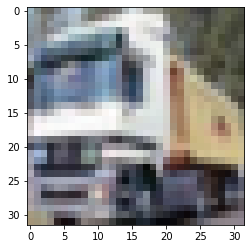

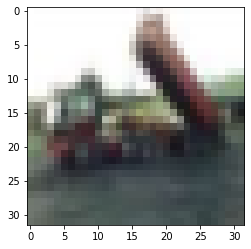

In [116]:
for i, data in enumerate(dataset):
    if i > 2:
        break
    img, label = data
    img = img.numpy().squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(class_label_to_name[label])
    plt.show()
    
for i, data in enumerate(cifar10):
    if i > 2: 
        break
    img, label = data
    plt.imshow(img)
    plt.show()


## What do you observe about the data?

### Solution
The data is black and white and all have black backgrounds. They are not natural images like those in Cifar-10.

## Looking at the data, how do you think each of these models will perform and why?

1. A basic CNN

2. A pre-trained model with no extra training

3. A pre-trained model with all but the last layer frozen

4. A basic CNN using a pre-trained model for feature extraction

### Solution
Any answer is fine.

# Part b
Now we will implement a basic CNN in order to benchmark performance on this task. Fill in the get_width function the same as you did in question 2. You may use your code from previous parts or choose a new architecture for this problem.

In [117]:
class ConvNet(nn.Module):
    def __init__(self, num_classes, input_width, input_height, num_channels, num_layers=2, num_filters=[10, 20], kernel_sizes=[5, 5], pool=[True, True]):
        super(ConvNet, self).__init__()
        
        assert len(num_filters) == num_layers, 'length of num_filters must match num_layers'
        assert len(kernel_sizes) == num_layers, 'length of kernel_sizes must match num_layers'
        assert len(pool) == num_layers, 'length of pool must match num_layers'
        
        self.num_classes = num_classes
        num_filters = [num_channels] + num_filters

        self.widths = [input_width]
        self.heights = [input_height]

        layers = []
        for layer in range(num_layers):
            layers.append(nn.Conv2d(num_filters[layer], num_filters[layer + 1], kernel_size=kernel_sizes[layer]))

            if pool[layer]:
                layers.append(nn.MaxPool2d(kernel_size=2))
            layers.append(nn.ReLU())

            self.widths.append(self.get_width(self.widths[-1], kernel_sizes[layer], pool[layer]))
            self.heights.append(self.get_width(self.heights[-1], kernel_sizes[layer], pool[layer]))
        
        self.convs = torch.nn.Sequential(*layers)

        self.ff_in_dim = self.widths[-1] * self.heights[-1] * num_filters[-1]
        self.fc1 = nn.Linear(self.ff_in_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        
        return self.fc2(x)
    
    # assume max pool with filter width 2 and stride 2
    def get_width(self, input_width, kernel_size, pool):
        ### TODO complete this function
        conv_width = (input_width - (kernel_size - 1))
        if pool:
            conv_width = conv_width // 2
        ### End TODO
        return conv_width
    

Now we will create our simple CNN just like we did in problem 2. Determine the size of our input and output (how did you do this in problem 2?) and print out the model architecture and verify this is what you expect.

In [118]:
# TODO create the ConvNet with the correct input and output size
num_classes = 10
input_width = 28
input_height = 28
num_channels = 1

# End TODO
cnn = ConvNet(num_classes, input_width, input_height, num_channels)
print(cnn)

ConvNet(
  (convs): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc1): Linear(in_features=320, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Now we will define a training loop and train our CNN on this dataset. Fill in the code below in order to complete the training loop. You may use code from previous parts if you would like, but it is good to get practice with this since it is a fairly common pattern.

In [121]:
def train_model(model, dataloaders, criterion, num_epochs=25):
    """Train a model and save best weights
    
    Adapted From:
        https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    
    Args:
        model (nn.Module): Model to train
        dataloaders ([dataloader, dataloader]): Training dataloader and validation dataloader
        criterion (function): Loss function
        optimizer (torch.optim): Optimizer for training
        num_epochs (int, optional): Number of epochs to train for. Defaults to 25.
    Returns:
        (model, validation_accuracy): Model with best weights, Array of validation loss over training
    """
    since = time.time()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    ### TODO complete training loop
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### end TODO
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def visualize_model(model, dataloaders, num_images=6):
    # @source https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_label_to_name[preds[j].item()]))
                plt.imshow(inputs.data[j].numpy().transpose(1, 2, 0).squeeze().clip(0, 1), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Run the cell below in order to train your cnn. This should take about ~5 minutes for 10 epochs if you're using the default architecture. Does the performance match what you were expecting?

In [120]:
# train the model
batch_size = 32
train_data_loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)

dataloaders = {'train':train_data_loader, "val": val_data_loader}
criterion = nn.CrossEntropyLoss()

trained_model, val_acc = train_model(cnn, dataloaders, criterion, num_epochs=10)

Epoch 0/9
----------


KeyboardInterrupt: 

In [122]:
# Visualize validation loss and some predictions
plt.plot(range(len(val_acc)), val_acc)
plt.title("Val Accuracy for basic CNN")
plt.show()

visualize_model(trained_model, dataloaders, num_images=6)

NameError: name 'val_acc' is not defined

## Your observations here
Was this what you expected?

### Solution
This model performs fairly well, achieving around 90% accuracy by the 10th epoch.

# Part c
Now we will use a pre-trained model with no fine-tuning. Because we will not be fine-tuning the model, we are not going to change the input or output size. This is possible because we are using a resnet18 that is pre-trained on CIFAR-10, which happens to have the same number of classes as our new dataset. 

Run the cell below to examine the architecture of our pre-trained model. What do you notice?

In [40]:
# TODO print out resnet-18
resnet = resnet18(pretrained=True)
print(resnet)
# end of TODO

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Your observations here
How does this model compare to our previous one? Do you see any problems with the existing architecture?

### Solution
This model is much larger than our previous one. In addition, this model takes in a 3 channel image, but our images are only one channel.


Run the cells below to see the accuracy of the pre-trained model on our data. This will take around 5 minutes. Make sure to read through the code to understand what is going on.

In [41]:
def prediction_accuracy(model, dataloaders):
    """Computes accuracy on train and validation set"""
    since = time.time()
    
    model.eval()   # Set model to evaluate mode
    
    loss = {}
    acc = {}
    
    with torch.no_grad():
        for phase in ['train', 'val']:
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                # statistics
                running_corrects += torch.sum(preds == labels.data)

            acc[phase] = running_corrects.double() / len(dataloaders[phase].dataset)


    time_elapsed = time.time() - since
    print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Training Accuracy: ", acc['train'], "Validation Accuracy: ", acc['val'])
    
    return acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


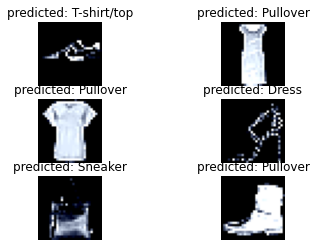

In [56]:
batch_size = 64

# as you may have noticed in the previous part, the pre-trained resnet takes in 3 
# channel images and our data has only one channel, to circumvent this, we stack
# the single channel 3 times before passing it through our model
trfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                            transforms.Normalize([0.4914, 0.4822, 0.4466], [0.2470, 0.2435, 0.2616]),
                            ])

# create datasets with transformations
dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, download=True)
val_dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, train=False, download=True)

# create dataloaders for training loop
train_data_loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
dataloaders = {'train':train_data_loader, "val": val_data_loader}

acc = prediction_accuracy(resnet, dataloaders)
visualize_model(resnet, dataloaders, num_images=6)

## Your observations here
How does this performance compare to your basic CNN? Why is this the case? Is this what you expected?

### Solution
This does not work at all. The accuracy is in fact worse than guessing at random. This is because we have not done any fine-tuning to our model and it was trained for a very different task. That is to say, this model is predicting the 10 cifar-10 classes and not the actual classes that we intend. This is why fine-tuning is very important.

# Part d
Now we will fine-tune our model on our new task by unfreezing just the last layer of our model. This part may look similar to the previous question, but is one of the most important concepts when using pre-trained models so it is good to get some practice with this.

First, let's freeze all of the layers except the last layer.

In [57]:
finetuned_resnet = resnet18(pretrained=True)

# TODO freeze all layers
for params in finetuned_resnet.parameters():
    params.requires_grad = False
# End TODO

# TODO re-initilize the last layer
finetuned_resnet.fc = nn.Linear(finetuned_resnet.fc.in_features, 10)
# End TODO

print(finetuned_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now let's train our model on our new task. Run the cells below. This will take around an hour to run 10 epochs. You may use 5 epochs but you may not get as good results.

In [58]:
# train the model
finetuned_resnet, val_acc_resnet = train_model(finetuned_resnet, dataloaders, criterion, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6178 Acc: 0.4247
val Loss: 1.5667 Acc: 0.4434

Epoch 1/9
----------
train Loss: 1.5618 Acc: 0.4467
val Loss: 1.5461 Acc: 0.4553

Epoch 2/9
----------
train Loss: 1.5446 Acc: 0.4541
val Loss: 1.5368 Acc: 0.4581

Epoch 3/9
----------
train Loss: 1.5318 Acc: 0.4586
val Loss: 1.5186 Acc: 0.4611

Epoch 4/9
----------
train Loss: 1.5208 Acc: 0.4638
val Loss: 1.5105 Acc: 0.4619

Epoch 5/9
----------
train Loss: 1.5101 Acc: 0.4665
val Loss: 1.4973 Acc: 0.4686

Epoch 6/9
----------
train Loss: 1.5012 Acc: 0.4701
val Loss: 1.4833 Acc: 0.4715

Epoch 7/9
----------
train Loss: 1.4944 Acc: 0.4711
val Loss: 1.4794 Acc: 0.4715

Epoch 8/9
----------
train Loss: 1.4834 Acc: 0.4740
val Loss: 1.4715 Acc: 0.4812

Epoch 9/9
----------
train Loss: 1.4790 Acc: 0.4761
val Loss: 1.4573 Acc: 0.4897

Training complete in 46m 3s
Best val Acc: 0.489700


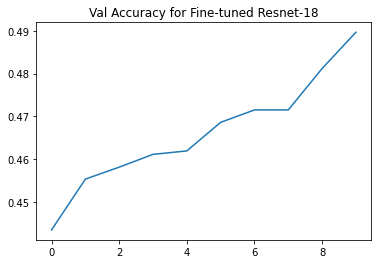

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


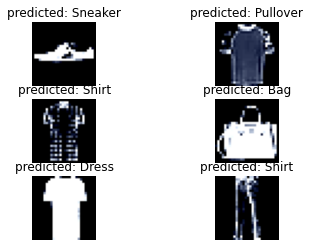

In [59]:
# Visualize validation loss and some predictions
plt.plot(range(len(val_acc_resnet)), val_acc_resnet)
plt.title("Val Accuracy for Fine-tuned Resnet-18")
plt.show()

visualize_model(finetuned_resnet, dataloaders, num_images=6)

## Your observations here
How does this performance compare to your basic CNN and the pre-trained model without fine-tuning? Why is this the case? Is this what you expected? 

### Solution
After fine-tuning for 10 epochs, the accuracy is around 50%. This is a lot better than before, but is not nearly as good as the basic CNN. The validation accuracy was going up steadily throughout the 10 epochs, so it may reach the same accuracy as the basic CNN after being trained for awhile, but this is diminishing returns since it takes so long to train. Thus we must look for a better option.

The reason for this behaviour is probably due to the large difference between CIFAR-10 and Fashion-MNIST. Fashion-MNIST has black and white images and all contain black backgrounds. These are very different than CIFAR-10 as those are all natural images.

# Part e
Now we will try a combination of the previous approaches by using a pre-trained model as a feature extractor and train a basic CNN using these features. This is similar in spirit to fine-tuning more (or all) layers of our pre-trained model, however this would take quite a long time and thus we opt for a quicker approach. 

The idea here is that the features from lower levels of our pre-trained network are more generalizable and can transfer across different tasks better.

In [110]:
class FeaturizedConvNet(ConvNet):
    def __init__(self, num_classes, input_width, input_height, num_channels, num_layers=2, num_filters=[10, 20], kernel_sizes=[5, 5], pool=[True, True]):
        # instantiate ConvNet with input sizes (64, 14, 14) since this is the shape
        # of the extracted features. the kernel sizes are smaller because of the smaller shape
        super().__init__(num_classes, 14, 14, 64, kernel_sizes=[3, 3])
        
        resnet = resnet18(pretrained=True)
        # freeze all layers in resnet
        for params in resnet.parameters():
            params.requires_grad = False
        
        # use first 5 layers as feature extractor
        self.features = nn.Sequential(
            *list(resnet.children())[:-5]
        )

    def forward(self, x):
        # obtain features from resnet before passing through convnet
        x = self.features(x)
        return super().forward(x)

feature_extracted_cnn = FeaturizedConvNet(10, 28, 28, 3)

Run the cell below to train a your model with feature extraction. This should take about 15 minutes for 10 epochs.

In [111]:
# train the model
trained_feature_cnn, val_acc_feature_cnn = train_model(feature_extracted_cnn, dataloaders, criterion, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6715 Acc: 0.7593
val Loss: 0.4243 Acc: 0.8475

Epoch 1/9
----------
train Loss: 0.3741 Acc: 0.8652
val Loss: 0.3603 Acc: 0.8683

Epoch 2/9
----------
train Loss: 0.3224 Acc: 0.8831
val Loss: 0.3146 Acc: 0.8857

Epoch 3/9
----------
train Loss: 0.2888 Acc: 0.8962
val Loss: 0.3098 Acc: 0.8858

Epoch 4/9
----------
train Loss: 0.2660 Acc: 0.9038
val Loss: 0.2862 Acc: 0.8972

Epoch 5/9
----------
train Loss: 0.2503 Acc: 0.9096
val Loss: 0.2788 Acc: 0.9001

Epoch 6/9
----------
train Loss: 0.2371 Acc: 0.9137
val Loss: 0.2814 Acc: 0.8971

Epoch 7/9
----------
train Loss: 0.2265 Acc: 0.9174
val Loss: 0.2719 Acc: 0.9032

Epoch 8/9
----------
train Loss: 0.2181 Acc: 0.9199
val Loss: 0.2674 Acc: 0.9036

Epoch 9/9
----------
train Loss: 0.2093 Acc: 0.9233
val Loss: 0.2693 Acc: 0.9042

Training complete in 15m 30s
Best val Acc: 0.904200


In [112]:
# Visualize validation loss and some predictions
plt.plot(range(len(val_acc_feature_cnn)), val_acc_feature_cnn)
plt.title("Val Accuracy for CNN with ResNet features")
plt.show()

visualize_model(trained_feature_cnn, dataloaders, num_images=6)

NameError: name 'val_acc_feature_cnn' is not defined

## Your observations here
How does this performance compare to the previous models? Why is this the case? Is this what you expected?


### Solutions
This performs slightly better than the basic CNN. Another benefit is that we gain a fairly high accuracy very early on in training, whereas the accuracy for the basic CNN showed a more gradual trend towards 90% accuracy. This shows the power of the features extracted from resnet. We have seen the benefit of these features from previous sections, and now we see how these can still be useful even when the dataset is very different than the domain it was trained on. This goes to show how well these features have generalized, especially at earlier layers in the network.


## Final Takeaways
What are the main takeaways from this notebook? Which method achieved the highest accuracy? Why was this/How did the dataset and task impact performance? Compare and contrast this to what you have learned in problems 1 and 2. 

## Solution
The main takeaway from this notebook is that there are many use cases for pre-trained models, but this is not a "one-size fits all" solution. How we can use pre-trained models depends very heavily on the task that we are trying to achieve and the model we are trying to use. Hopefullly the fine-tuning section showed how detrimental it can be to try to use a pre-trained model without fully understanding what is going on under the hood. Furthermore, this yields a better understanding for the difference between earlier/later layers in Resnet and other pre-trained models that one can use.